In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

import matplotlib.pyplot as plt

## Load Stable Diffusion

In [2]:
from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

def load_model_from_config(config, ckpt, device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model

In [ ]:
device = torch.device("cuda:0")
torch.cuda.set_device(0) # For multiple GPUs

config_path = "configs/stable-diffusion/v1-inference.yaml"
model_path = ""

config = OmegaConf.load(config_path)
model = load_model_from_config(config, model_path, device)

Loading model from /nfs/130.245.4.102/add_disk2/agraikos/stable_diffusion_ckpts/v1-5-pruned-emaonly.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/agraikos/anaconda3/envs/ldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Compare Inexact Newton to Gradient Descent

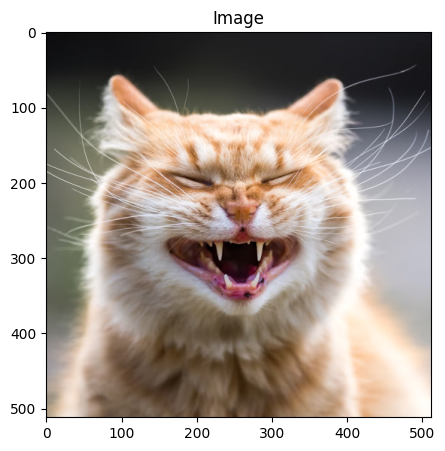

In [4]:
# Load image
img_path = "../assets/thecat.jpg"

img = np.asarray(Image.open(img_path).resize((512,512)))[:,:,:3]
img = torch.from_numpy(img.copy())
img = (img.permute([2,0,1]) / 125.7 - 1).unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax.set_title("Image")
plt.show()

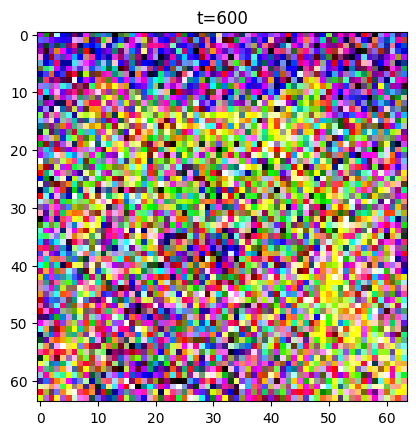

In [14]:
# Sample noisy diffusion latent
t = 600
atbar = model.alphas_cumprod[t-1].view(1,1,1,1)

with torch.no_grad():
    x0_latent = model.get_first_stage_encoding(model.encode_first_stage(img))
xt = torch.sqrt(atbar)*x0_latent + torch.sqrt(1-atbar)*torch.randn_like(x0_latent)

plt.figure()
plt.imshow((0.5*(xt+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0])[:,:,:3])
plt.title(f't={t}')
plt.show()

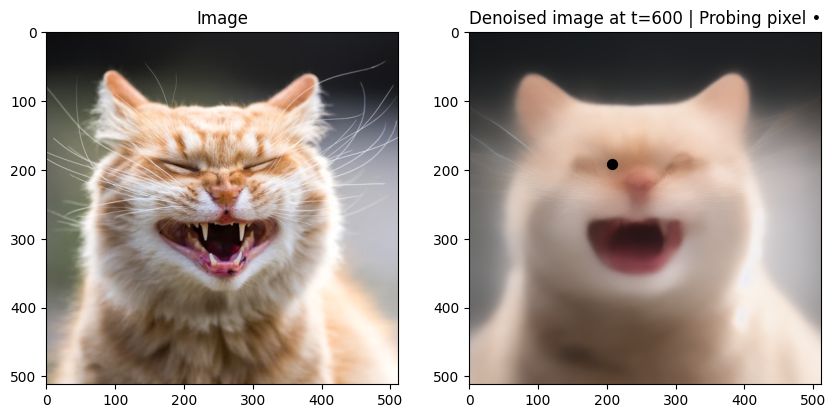

In [15]:
def model_pred(model, x, t, cond):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
            epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon

# Text conditioning
caption = ''
with torch.no_grad():
    cond = model.get_learned_conditioning(caption).tile(1,1,1)

# Pixel to probe (in latent space coordinates)
h, w = 24, 26

with torch.no_grad():
    epsilon = model_pred(model, xt, t, cond)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
    pred_img = model.decode_first_stage(x0_pred)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((0.5*(img+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy())
ax[0].set_title("Image")
ax[1].imshow((0.5*(pred_img+1)).clamp(0,1)[0].permute([1,2,0]).cpu().numpy())
ax[1].set_title(f"Denoised image at t={t} | Probing pixel •")
ax[1].scatter([w*512/64], [h*512/64], c='k', s=50)
plt.show()

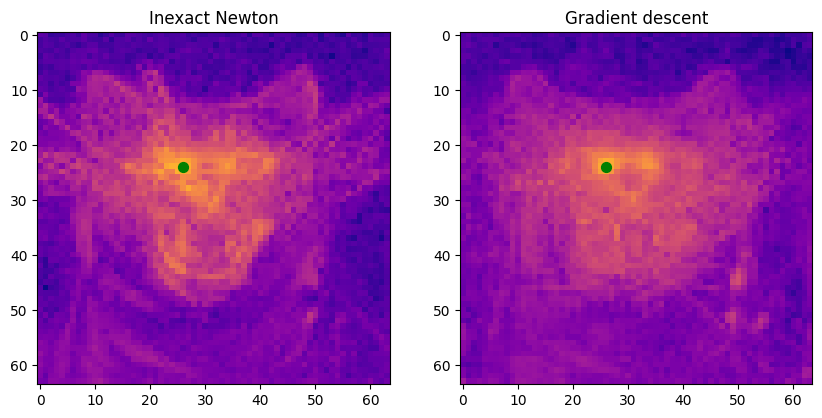

In [16]:
## Forward Difference ##
xt.requires_grad = False

epsilon = model_pred(model, xt, t, cond)
x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

def jacobian_vector(error_dir):
    h = 1.
    h_adaptive = h / error_dir.abs().max()
    xt_error_dir = xt + h_adaptive*error_dir
    epsilon_error_dir = model_pred(model, xt_error_dir, t, cond)
    x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)

    grad = (x0_pred_error_dir - x0_pred) / h_adaptive
    return grad

Jpix_fw = 0
for i in range(4):
    v = torch.zeros((1*4*64*64), device=device)
    col_idx = np.ravel_multi_index((0,i,h,w), (1,4,64,64))
    v[col_idx] = 1
    Jpix_fw += jacobian_vector(v.view(1,4,64,64))**2
Jpix_fw = torch.sqrt(Jpix_fw).log()
## ################## ##

## Backprop ##
def denoiser(x):
    t_cond = torch.tensor(x.shape[0]*[t-1]).view(-1).float().to(device)
    epsilon = model.model.diffusion_model(x, t_cond, context=cond.tile(x.shape[0],1,1))
    x0_pred = x / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
    
    return x0_pred

xt.requires_grad = True
Jpix_bp = 0
for i in range(4):
    xt.grad = None
    x0_pred = denoiser(xt)

    mask_ij = torch.zeros_like(xt)
    mask_ij[:,i,h,w] = 1
    output_ij = (mask_ij*x0_pred).sum()
    Jpix_bp += torch.autograd.grad(output_ij, xt, retain_graph=True)[0]**2
Jpix_bp = torch.sqrt(Jpix_bp).log()
## ######## ##

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(Jpix_fw.mean(1)[0].cpu().numpy(), cmap='plasma')
ax[0].set_title("Inexact Newton")
ax[0].scatter([w], [h], c='g', s=50)
ax[1].imshow(Jpix_bp.mean(1)[0].cpu().numpy(), cmap='plasma')
ax[1].set_title("Gradient descent")
ax[1].scatter([w], [h], c='g', s=50)
plt.show()